- [Training](#Training)

# Training

In [1]:
import os
from PIL import Image

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import resnet18

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Hyperparameters

In [2]:
CROP_SIZE = 256
IMAGE_SIZE = 224

BATCH_SIZE = 256

LR = 0.0001
EPOCHS = 20

In [3]:
# Reading the Datafarme
data = pd.read_csv('./dataset/train_challenge.csv')
data.head()

,0,1
0,0.jpg,Adhered
1,1.jpg,Adhered
2,2.jpg,Concrete
3,3.jpg,Concrete
4,4.jpg,Plastic & fabric


In [4]:
# Setup Classes
CLASSES = ['Adhered', 'Ballasted', 'Concrete', 'Plastic & fabric', 'Shingle', 'Steel']

classes_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
idx_to_classes = {idx: cls for idx, cls in enumerate(CLASSES)}

In [5]:
# replace '1' column with classes_to_idx dict
data = data.replace({'1': classes_to_idx})
data.head()

,0,1
0,0.jpg,0
1,1.jpg,0
2,2.jpg,2
3,3.jpg,2
4,4.jpg,3


In [6]:
# Make X and Y from dataframe
X = data['0'].values
Y = data['1'].values

In [7]:
# Split into train, validation and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

print(f"Train size: {len(X_train)}\nValidation size: {len(X_val)}\n")

Train size: 6915
Validation size: 1729



## Torch Dataset and Dataloader

In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, dataroot: str, X_array: np.array, Y_array: np.array, transform = None, target_transform = None):
        self.dataroot = dataroot
        self.X_array = X_array
        self.Y_array = Y_array
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        file_name = self.X_array[index]
        img = Image.open(os.path.join(self.dataroot, file_name)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            
        label = np.array(self.Y_array[index])
        if self.target_transform is not None:
            label = self.target_transform(label)
        else:
            label = torch.from_numpy(label)

        return {'image': img, 'label': label, 'image_name': file_name}

    def __len__(self):
        return len(self.X_array)

### Datasets

In [9]:
train_dataset = SatelliteDataset(dataroot='./dataset/train/', X_array=X_train, Y_array=y_train, 
                                 transform=transforms.Compose([
                                                               transforms.Resize(CROP_SIZE),
                                                               transforms.RandomHorizontalFlip(),
                                                               transforms.CenterCrop(IMAGE_SIZE),
                                                               transforms.ToTensor(),
                                                               transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                    [0.2558, 0.2532, 0.2457])]))

val_dataset = SatelliteDataset(dataroot='./dataset/train/', X_array=X_train, Y_array=y_train, 
                               transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                             transforms.CenterCrop(IMAGE_SIZE),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                  [0.2558, 0.2532, 0.2457])]))

### Dataloaders

In [10]:
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## CUDA

In [11]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    print(f"Using {torch.cuda.get_device_name()} for Training")
else:
    print("Using CPU for Training")

Using Tesla T4 for Training


## Models

In [12]:
class ResnetModel(nn.Module):
    def __init__(self):
        super(ResnetModel, self).__init__()
        r = resnet18(pretrained=True)
        fc = nn.Linear(r.fc.in_features, len(CLASSES))
        r.fc = fc
        self.model = r
        
    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

In [13]:
model = ResnetModel()
model = model.to(device)
model

ResnetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

## Loss and Optimizer

In [14]:
# Loss
criterion = nn.NLLLoss().cuda() if torch.cuda.is_available() else nn.NLLLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

## LR scheduler

In [15]:
scheduler = lr_scheduler.StepLR(optimizer, 5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.


## Training

In [ ]:
train_losses = []
test_losses = []
accuracies = []
better_accuracy = 0.0

for epoch in range(1, EPOCHS + 1):
    #Training
    train_loss = 0.0
    test_loss = 0.0
    accuracy = 0.0
    
    model.train()
    for data in trainloader:
        x = data['image'].to(device)
        y = data['label'].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    
    model.eval()
    with torch.no_grad():
        for data in valloader:
            x = data['image'].to(device)
            y = data['label'].to(device)
            out = model(x)
            loss = criterion(out, y)
            test_loss += loss.item() * x.size(0)
            accuracy += accuracy_score(y.cpu().numpy(), torch.exp(out).argmax(1).cpu().numpy()) * x.size(0)
        
    train_loss /= len(trainloader.dataset)
    test_loss /= len(valloader.dataset)
    accuracy /= len(valloader.dataset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
    print(f'Saving model for Epoch {epoch}')
    torch.save(model.state_dict(), f'./models/model_{epoch}.pt')
    
    if accuracy > better_accuracy:
        better_accuracy = accuracy
        torch.save(model.state_dict(), './models/model_best.pt')
        print(f"Saving improved Model for Epoch {epoch}")
    else:
        print("Model is not improved for this time")
    
    if scheduler is None:
        print("No Schedular found. LR will not change")
    else:
        if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss)
        else:
            scheduler.step()
        
    print(f"[Epoch: {epoch}/{EPOCHS}] training loss: {train_loss} validation loss: {test_loss}, accuracy: {accuracy}")
    
print("End of training!!")

Saving model for Epoch 1
Saving improved Model for Epoch 1
Adjusting learning rate of group 0 to 1.0000e-04.
[Epoch: 1/20] training loss: 0.8877061809479803 validation loss: 0.5011057774161224, accuracy: 0.8229934924078091
Saving model for Epoch 2
Saving improved Model for Epoch 2
Adjusting learning rate of group 0 to 1.0000e-04.
[Epoch: 2/20] training loss: 0.43920582476855186 validation loss: 0.33033157908940175, accuracy: 0.8896601590744758
Saving model for Epoch 3
Saving improved Model for Epoch 3
Adjusting learning rate of group 0 to 1.0000e-04.
[Epoch: 3/20] training loss: 0.33202257379620126 validation loss: 0.27630143846753535, accuracy: 0.9125090383224873
Saving model for Epoch 4
Saving improved Model for Epoch 4
Adjusting learning rate of group 0 to 1.0000e-04.
[Epoch: 4/20] training loss: 0.24241272422255422 validation loss: 0.22571264357667684, accuracy: 0.9181489515545914
Saving model for Epoch 5
Saving improved Model for Epoch 5
Adjusting learning rate of group 0 to 1.000

### Training Stats

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

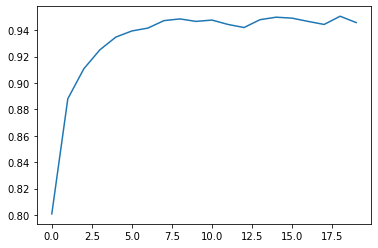

In [67]:
plt.plot(accuracies)

In [68]:
train_losses

[1.0138728725030985,
 0.4576777295107783,
 0.35864640212283133,
 0.2987881768723803,
 0.2255530750760115,
 0.212126887473867,
 0.19999943744291537,
 0.19310804978497892,
 0.1862424666822948,
 0.18614838275026774,
 0.18638731699789768,
 0.18402824462192782,
 0.1839700485689435,
 0.18447449869292418,
 0.18505550535881943,
 0.18498952816296382,
 0.18436532563604657,
 0.1850129894044894,
 0.18461198096506334,
 0.18250264148305312]

In [69]:
test_losses

[0.5601876224587125,
 0.3477129156617091,
 0.27352861835960024,
 0.250325299345835,
 0.20851717106216813,
 0.19224109280846383,
 0.19147077230541326,
 0.18022449408117103,
 0.17901863205210936,
 0.17890834109460368,
 0.17647851671288173,
 0.184427017871013,
 0.18164609727151396,
 0.17806966908798647,
 0.1752669436931179,
 0.17696222002447642,
 0.17952873134421252,
 0.1809442790242657,
 0.17564729467163634,
 0.18155874904791944]

In [70]:
accuracies

[0.8008676789587853,
 0.8880694143167028,
 0.9107736804049168,
 0.9250903832248735,
 0.9347794649313087,
 0.93940708604483,
 0.9415762834417932,
 0.9472161966738973,
 0.9485177151120752,
 0.9466377440347071,
 0.9476500361532899,
 0.9443239334779465,
 0.9420101229211858,
 0.9479392624728851,
 0.9498192335502531,
 0.9490961677512654,
 0.9466377440347071,
 0.9443239334779465,
 0.9505422993492407,
 0.9457700650759219]

# Testing on training data

In [ ]:
y_true = np.empty(0)
y_pred = np.empty(0)

model.eval()
with torch.no_grad():
    for data in testloader:
        x = data['image'].to(device)
        y = data['label'].to(device)
        out = model(x)
        out = torch.exp(out).argmax(1)
        y_true = np.append(y_true, y.cpu().numpy())
        y_pred = np.append(y_pred, out.cpu().numpy())

In [ ]:
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Testing

In [15]:
# Reading the Datafarme
test_data = pd.read_csv('./dataset/test_challenge.csv')
test_data = test_data.replace({'1': classes_to_idx})
test_data.head()

,0,1
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [74]:
CENTER_CROP_FIVE = False

In [75]:
if CENTER_CROP_FIVE:
    testset = SatelliteDataset(dataroot='./dataset/test/', X_array=test_data['0'].values, Y_array=test_data['1'].values, 
                               transform=transforms.Compose([transforms.Resize(256),
                                                             transforms.FiveCrop(IMAGE_SIZE),
                                                             transforms.Lambda(lambda crops: torch.stack([
                                                                 transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                      [0.2558, 0.2532, 0.2457])(
                                                                     transforms.ToTensor()(crop)) for crop in crops]))
                                                            ]))

else:
    testset = SatelliteDataset(dataroot='./dataset/test/', X_array=test_data['0'].values, Y_array=test_data['1'].values, 
                               transform=transforms.Compose([transforms.Resize(CROP_SIZE),
                                                             transforms.CenterCrop(IMAGE_SIZE),
                                                             transforms.ToTensor(),
                                                             transforms.Normalize([0.4728, 0.4762, 0.4692],
                                                                                  [0.2558, 0.2532, 0.2457])]))

In [76]:
testsetloader = DataLoader(testset, batch_size=32, shuffle=False)

In [77]:
len(testsetloader.dataset)

596

In [78]:
def infarence_and_save(epoch):
    model.load_state_dict(torch.load(f'./models/model_{epoch}.pt'))

    y_test_pred = np.empty(0)

    model.eval()
    with torch.no_grad():
        for data in testsetloader:
            x = data['image'].to(device)
            if CENTER_CROP_FIVE:
                bs, ncrops, c, h, w = x.size()
                out = torch.exp(model(x.view(-1, c, h, w)))
                out, _ = out.argmax(1).view(bs, ncrops).median(1)
                y_test_pred = np.append(y_test_pred, out.cpu().numpy())
            else:
                out = model(x)
                out = torch.exp(out).argmax(1)
                y_test_pred = np.append(y_test_pred, out.cpu().numpy())

    y_test_pred.shape

    d = {'0': test_data['0'].values, '1': y_test_pred.astype(int)}
    pd.DataFrame(d).replace({'1': idx_to_classes}).to_csv(f'./output_{epoch}.csv', index=False)

In [79]:
for i in range(1, 21):
    print(f"Working for epoch {i}")
    infarence_and_save(i)

Working for epoch 1
Working for epoch 2
Working for epoch 3
Working for epoch 4
Working for epoch 5
Working for epoch 6
Working for epoch 7
Working for epoch 8
Working for epoch 9
Working for epoch 10
Working for epoch 11
Working for epoch 12
Working for epoch 13
Working for epoch 14
Working for epoch 15
Working for epoch 16
Working for epoch 17
Working for epoch 18
Working for epoch 19
Working for epoch 20
